Text processing 6 (Diagne's sentences + additional sentences)
----------------------

In [1]:
# importations
import re
import spacy
import nltk
import pandas as pd
from typing import *
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

# define a style for the matplotlib plots
plt.style.use("ggplot")

c:\Users\Oumar Kane\AppData\Local\pypoetry\Cache\virtualenvs\pytorch1-HleOW5am-py3.10\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We obtained new paragraphs after matching the French paragraphs with their Wolof counterparts. It is time to make further processing of the text. Notably, we want to process the text as follows:

1. Load and print the parallel corpus;

2. Identify the length of each paragraph in each corpus and compare them;

3. Identify the longest and shortest paragraphs;

4. Modify the pre-created nlp pipeline class for that project; 

5. Identify the options to add to `spacy` (if it is used) to find the tokens;

6. Use the pre-created nlp pipeline class to recuperate the tokens;

7. Identify the nlp pipeline sub-steps.

### Add additional corrections to the text

In [2]:
# Load the data frame and make a copy
ad_sentences = pd.read_csv("data/extractions/new_data/ad_sentences.csv")

corpora = ad_sentences.copy()

In [3]:
# print the head
corpora.head()

,french,wolof
0,Il n'a pas encore été,Demagul
1,Il n'a pas encore été voir,Seeteegul
2,Il ne s'est pas encore substitué à,Wuutóogul
3,Il n'a pas encore pris de contacts,Giséegul
4,Homme n'est pas mauvais !,Nit bonul !


Let us display more clearly the corpora by printing the dictionary version of it.

In [4]:
corpora_dict = corpora.to_dict(orient='index')

corpora_dict

{0: {'french': "Il n'a pas encore été", 'wolof': 'Demagul'},
 1: {'french': "Il n'a pas encore été voir", 'wolof': 'Seeteegul'},
 2: {'french': "Il ne s'est pas encore substitué à", 'wolof': 'Wuutóogul'},
 3: {'french': "Il n'a pas encore pris de contacts", 'wolof': 'Giséegul'},
 4: {'french': "Homme n'est pas mauvais !", 'wolof': 'Nit bonul !'},
 5: {'french': "L'homme n'est pas mauvais !", 'wolof': 'Nit bonul !'},
 6: {'french': "Quelqu'un est parti !", 'wolof': 'Nit dem na !'},
 7: {'french': 'Homme est parti !', 'wolof': 'Nit dem na !'},
 8: {'french': 'Un homme est parti !', 'wolof': 'Nit dem na !'},
 9: {'french': "J'ai vu lion.", 'wolof': 'Gis naa gaynde.'},
 10: {'french': "J'ai vu un lion.", 'wolof': 'Gis naa gaynde.'},
 11: {'french': "C'est un homme.", 'wolof': 'Nit la.'},
 12: {'french': 'Cet homme près de moi.', 'wolof': 'Nit kii ci sama wet.'},
 13: {'french': 'Cet homme là près de toi.', 'wolof': 'Nit kookuu ci sa wet.'},
 14: {'french': 'Tu vois cet homme là-bas ?', 'wo

### Count the number of letters and words

The first comparison made between the two corpora is between their lengths:

- First, we will define a length of a document to be the number of its letters
- Second, we will define a length of document to be the number of her words (separated by spaces only). 

Let us consider the two different types of lengths and show their distributions over the documents.

In [5]:
# length as number letters (space in count)
count_letters = lambda doc_: len(doc_)

corpora['french_n_letters'] = corpora['french'].map(count_letters)

corpora['wolof_n_letters'] = corpora['wolof'].map(count_letters)

# length as number of words
count_words_space = lambda doc_: len(doc_.split())

corpora['french_n_words'] = corpora['french'].map(count_words_space)

corpora['wolof_n_words'] = corpora['wolof'].map(count_words_space)


In [6]:
# print the first documents
corpora.head()

,french,wolof,french_n_letters,wolof_n_letters,french_n_words,wolof_n_words
0,Il n'a pas encore été,Demagul,21,7,5,1
1,Il n'a pas encore été voir,Seeteegul,26,9,6,1
2,Il ne s'est pas encore substitué à,Wuutóogul,34,9,7,1
3,Il n'a pas encore pris de contacts,Giséegul,34,8,7,1
4,Homme n'est pas mauvais !,Nit bonul !,25,11,5,3


Let us trace the distributions of the number of letters and the distributions of the numbers words separated by spaces.

In [7]:
# %%writefile wolof-translate/wolof_translate/utils/plots.py

import pandas as pd
import plotly.express as px

def plot_lengths(data_frame: pd.DataFrame, columns_regex: List = [".*n_letters", ".*n_words"]):
    
    fig = make_subplots(rows=len(columns_regex), cols=1, subplot_titles=columns_regex, y_title="Numbers", x_title="documents")
    
    for i, column in enumerate(columns_regex):
        
        columns = [column_ for column_ in data_frame.columns if re.search(column, column_)]
        
        for col_ in columns:
            
            # fig.add_trace(go.Histogram(
            #     x = data_frame[col_], name=col_
            # ), row=i+1, col=1)
            
            fig.add_trace(go.Scatter(
                y = data_frame[col_], name=col_
            ), row=i+1, col=1)
    
    fig.show()

plot_lengths(corpora)    

On the top of the figure we consider the distributions of the number of letters: the blue line indicates the distribution traced over the french corpus and the red line that traced over the wolof corpus.

On the bottom of the figure we consider the distributions of the number of words: the violet line indicates the distribution traced over the french corpus and the green line that traced over the wolof corpus.

We have the same distribution tendency both for the number of letters and for the number of words. Which is what we expected to find.

### Identify the shortest and the longest paragraphs

Identifying the longest and the shortest paragraphs will help us identify paragraphs with abnormal lengths and constitution. Let us display the 5 shortest and longest paragraphs. 

Let us consider, first, the length to be the number of letters.

In [8]:
# let us sort the corpora by number of letters 
sorted_corpora_french1 = corpora.sort_values(by="french_n_letters")[['french', 'french_n_letters']]

sorted_corpora_wolof1 = corpora.sort_values(by="wolof_n_letters")[['wolof', 'wolof_n_letters']]

# let us recuperate the top 10s
top_french_corpora = sorted_corpora_french1.head()

top_wolof_corpora = sorted_corpora_wolof1.head()

# let us recuperate the bottom 10s
bot_french_corpora = sorted_corpora_french1.tail()

bot_wolof_corpora = sorted_corpora_wolof1.tail()


Display the ten first paragraphs.


In [9]:
top_french_corpora

,french,french_n_letters
1026,Oui,3
321,Va !,4
1687,Oui.,4
650,Où ?,4
712,Oh !,4


In [10]:
top_wolof_corpora

,wolof,wolof_n_letters
712,Ex !,4
1201,Ndax,4
1026,Waaw,4
1687,Wau.,4
1214,Na ?,4


The shortest paragraph in the french corpus has 3 letters in it and the one in the wolof corpus has 4 letters in it. They contain both of them a normal length. 

Let us display ten last paragraphs.

In [11]:
bot_french_corpora

,french,french_n_letters
1780,Sur cette photo il semble qu'il y est un table...,569
1826,Cette photo ci c'est une photo sur laquelle je...,590
1806,"Oui, ceci est une chambre. Une large chambre d...",599
1852,Cela est ce qu'on appelle 'La tour la plus hau...,684
1786,"Jusqu'à présent, on voit sur la photo des sold...",747


In [12]:
bot_wolof_corpora

,wolof,wolof_n_letters
1837,"Asalaamu aleykum wa rahmatu laah, ba tey it ci...",558
1826,Nataal bi ab nataal la boo xamante yni maa ngi...,591
1852,Lii na ñuy wax 'la tour la plus haute au Sénég...,604
1806,"Waaw, lii nag moom lal la. Benn lal gu yànj bo...",643
1786,Ba tey ñoo ngi gis ci nataal bii ay soldat. So...,702


Since the longest paragraphs have not a abnormal number of letters compared with those preceding them we cannot say that they are abnormal. But let's trace the box plot of the length to verify our hypotheses.

In [13]:
px.box(data_frame=corpora, x = ["french_n_letters", "wolof_n_letters"])

For the `wolof_n_letters` we identify a upper fence of **44** letters. For the `french_n_letters` we identify a upper fence of **64** letters. Let us recuperated those documents.

In [14]:
french_abnormal_n_letters = corpora[corpora["french_n_letters"] > 64]["french"]
wolof_abnormal_n_letters = corpora[corpora["wolof_n_letters"] > 44]["wolof"]

# print those "abnormal" paragraphs
french_abnormal_n_letters.to_list(), wolof_abnormal_n_letters.to_list()

(["Le maître souhaiterait avoir donné toute sa fortune pour pouvoir demander aujourd'hui l'aumône.",
  'Viens pour que les enfants soient des travailleurs, soient des braves !',
  "Change-les à tel point qu'ils soient autres et que leur opinion aussi soit toute autre.",
  'Cet homme-ci, devant nous, et cet homme-là ne sont pas les mêmes.',
  'Des boeufs que tu vois dans cette ville, le plus gros appartient à ton père Alfa.',
  'Des boeufs que tu vois dans cette ville, celui le plus gros appartient à ton père Alfa.',
  'Mon salut à tout le monde mais surtout honore de ma part ceux-là que tu rencontras.',
  "Des gens que tu m'as présentés, celui que voici me dispose le plus à la confiance.",
  "Celui-ci est à moi mais j'ignore d'où provient cet autre-là près de toi.",
  "Les moutons sont peut-être déjà arrivés, mais j'en n'ai encore vu aucun.",
  "Le marabout implora qu'il fût dans la situation de quelqu'un qui aurait fait don de sa fortune, pour être en mesure de demander l'aumône.",
  

In [15]:
# print their indices
french_abnormal_n_letters.index, wolof_abnormal_n_letters.index


(Int64Index([ 804, 1163, 1164, 1237, 1379, 1380, 1382, 1383, 1387, 1389,
             ...
             1910, 1919, 1920, 1921, 1926, 1937, 1938, 1939, 1943, 1947],
            dtype='int64', length=195),
 Int64Index([ 804, 1163, 1164, 1379, 1380, 1382, 1386, 1387, 1424, 1427,
             ...
             1936, 1937, 1938, 1939, 1941, 1943, 1944, 1946, 1947, 1948],
            dtype='int64', length=208))

Let are consider now the length to be the number of words separated by spaces. We will plot directly the box plot.

In [16]:
px.box(data_frame=corpora, x = ["french_n_words", "wolof_n_words"])


For the `wolof_n_words` we identify a upper fence of **10** letters. For the `french_n_words` we identify a upper fence of **11** letters. It is the same as for the non augmented diagne's sentences. Let us recuperated those documents.

In [17]:
french_abnormal_n_words = corpora[corpora["french_n_words"] > 11]["french"]
wolof_abnormal_n_words = corpora[corpora["wolof_n_words"] > 10]["wolof"]

# print those "abnormal" paragraphs
french_abnormal_n_words.to_list(), wolof_abnormal_n_words.to_list()

(["Le maître souhaiterait avoir donné toute sa fortune pour pouvoir demander aujourd'hui l'aumône.",
  "C'est un homme de chair et d'os et tu es un homme !",
  'Viens pour que les enfants soient des travailleurs, soient des braves !',
  "Change-les à tel point qu'ils soient autres et que leur opinion aussi soit toute autre.",
  'Cet homme près de moi et celui là près de toi sont parents.',
  'Cet homme-ci, devant nous, et cet homme-là ne sont pas les mêmes.',
  'Des boeufs que tu vois dans cette ville, le plus gros appartient à ton père Alfa.',
  'Des boeufs que tu vois dans cette ville, celui le plus gros appartient à ton père Alfa.',
  'Mon salut à tout le monde mais surtout honore de ma part ceux-là que tu rencontras.',
  "Des gens que tu m'as présentés, celui que voici me dispose le plus à la confiance.",
  "Celui-ci est à moi mais j'ignore d'où provient cet autre-là près de toi.",
  "Les moutons sont peut-être déjà arrivés, mais j'en n'ai encore vu aucun.",
  "De toute manière, qu

In [18]:
# print their indices
french_abnormal_n_words.index, wolof_abnormal_n_words.index

(Int64Index([ 804, 1160, 1163, 1164, 1229, 1237, 1379, 1380, 1382, 1383,
             ...
             1919, 1920, 1921, 1926, 1937, 1938, 1942, 1943, 1946, 1947],
            dtype='int64', length=211),
 Int64Index([ 804, 1163, 1164, 1229, 1379, 1380, 1382, 1386, 1387, 1427,
             ...
             1923, 1926, 1927, 1936, 1937, 1938, 1939, 1943, 1946, 1947],
            dtype='int64', length=201))

### Modify the pre-create natural language processing class 

We created a nlp pipeline class to process and analyze the kaggle tweet competition text data set. The notebook of that project is available at the following github link [kaggle_tweet_nlp](https://github.com/Oumar199/nlp_programs_exercises/blob/master/kaggle_tweet_competition_eda_preprocessing.ipynb). The difference in our project is that **we don't treat tweets which contains urls, html, emojis, etc** but **a normal text from a book** and also that **we don't have a target to predict** but **in that place two corpus in place of one**. **Each corpus will be processed differently** and the **discretized version of the tokens will represent the inputs of the model**. 

- Modify the tokenizer function 

    The tokenizer function use a spacy model to identify the tokens inside each document. A list of tokens is provided after processing on each of them. The function need some arguments in order to process correctly the documents. But some of them are not important in the current project and will be deleted. Another thing is to not take the lower case of the words and keep them as they are. We don't want to make an important number of processing on the tokens since we are making a translation task:
    - natural language processing object (created with spacy)
    - the corpus (a list of documents)
    - boolean arguments specifying if we want to:
        - ~~remove the stopwords~~: The stopwords are a part of the text
        - ~~remove the non ascii terms~~: We will keep non ascii terms if they are present in the text 
        - ~~collect only alphanumerical tokens~~: Non alphanumerical tokens like parentheses will be important for the translation
        - ~~delete the punctuations~~: The punctuations are a part of the text 
        - trim the spaces
        - ~~keep urls~~: The text doesn't contain urls
        - ~~keep html expression~~: The text doesn't contain html expression
        - ~~keep emojis~~: The text doesn't contain emojis
        - ~~keep mentions~~: The text doesn't contain camel cased tokens
        - ~~keep upper cased words~~: All upper cased or capitalized words are important for the translation.
        - ~~lem the tokens~~: No lemmatization is required 
    - ~~the minimum length of a token (to delete the emojis)~~: If minimum is added punctuations will be deleted
    - ~~the maximum length of a token~~: All words with multiple letters are important
    - ~~list of entity types to delete~~: We cannot identify all of the entities and we will maybe need to process them manually (after their identification)
    - ~~list of pos tags to keep (if not specified we can keep all of the pos tags)~~: We cannot identify all of them (particularly in the wolof corpus)

    The main purpose of the modification is to keep most tokens as possible.

In [19]:
%run wolof-translate/wolof_translate/utils/tokenize_text.py

- Modify the nlp pipeline class:

    We created the nlp pipeline class in order to manipulate a data frame containing a corpus and the target of each document in the corpus. In our case we want to provide only the corpus and we don't need a target column since we are making translation over two corpora. Only one corpus will be provided at a time to the class but we can also transfer the pipeline to other corpora. The tokenization method step will be adapted for the previous tokenization function. The pipeline of the class were composed of the following steps:
    - tokenize_text ⚡
    - create_corpus: That corpus is different of the provided corpus
    - create_frequency
    - show_frequency_out_limits
    - show_most_common_words
    - plot_frequency_histogram
    - show_n_time_frequency_words
    - delete_n_time_frequency_words
    - ~~stem words (if no lemming)~~
    - ~~corpus_filter~~
    - ~~get_words_w_same_targets~~
    - remove_words
    - ~~remove_words_w_same_targets~~
    - recuperate_results ⚡
    - ~~add_results_to_data_frame~~
    - add_results_to_corpus 🕯️
    - plot_wordcloud
    - create_n_grams
    - set_n_grams_as_corpus
    - ...
    - reset_corpus
    - predict_next_word

    The strikethrough steps are those that we will not add in our pipeline. The step with the flash emoji in their front are the modified steps. The one with a candle in front of it is a new method.

In [20]:
# !pip install -e wolof-translate --quiet

Let us import bellow the nlp pipeline class.

In [21]:
%run wolof-translate/wolof_translate/pipe/nlp_pipeline.py

### Identify supplementary options for spacy tokenization

The Wolof corpus contains suffixes like the following: `'a(a)', 'i(i)', 'u(u)', 'o(o)', 'e(e)', 'al(e)', 'aleek', 'alee', 'ant(e)', 'y', 'iy', 'ay', 'oy', 'am', 'ul', 'ati', '(a)di', 'an', '(w)aan', '(w)oon'`. It also contains prefixes, but suffixes could be more productive. 

However, the suffixes cannot all be identified since some words finish with them but are not concerned (all of them must be identified, which can take a long time since the book doesn't have all the words). Another thing is that we must create grammar rules to recompose the words after translation. So we take the tokens to their original form (without specifying suffixes and infixes).

The same thing is observed in the French languages or corpus but will require a more complicated task than specifying the suffixes and the prefixes (which can be productive in French) for the tokenization. Lemming or stemming the tokens will remove their suffixes or the text semantics. 

**Conclusion**: We will not separate the text to simplify the task and keep the `text semantic/contexts`, which is very important to make machine translation. 

### Tokenization

Let us specify the pipeline for the tokenization:

- tokenize_text: Delete all tokens with space only and recuperate the list of the list of tokens for each document
- create_corpus: Stacked the tokens in one list to obtain the tokens of the corpus and recuperate it
- create_frequency: Determine the frequency of the tokens 
- show_frequency_out_limits (?)
- show_most_common_words: Show most common words
- plot_frequency_histogram: Plot frequency histogram (bottom n, with n the number that we will specify)
- show_n_time_frequency_words: We must recuperate the words with lowest frequencies
- delete_n_time_frequency_words (?)
- remove_words (?)
- recuperate_results: Recuperate the results (tokens with frequencies and token indices)
- add_results_to_corpus (?)
- plot_wordcloud: Plot the Word Cloud of the corpus


The steps with no interrogation marks are the obligatory steps. Another step can be avoided if necessary. Let us begin with the French corpus and add the same pipeline to the Wolof corpus. 

We will use the large french model of spacy for the tokenization.

In [22]:
nlp = spacy.load('fr_core_news_lg')

- French corpus

In [23]:
with TextPipeProcessing(corpora['french'].to_list()) as pipeline1:
    
    # tokenize the text 
    pipeline1(pipeline1.tokenize_text, nlp = nlp)
    
    # create the corpus
    pipeline1(pipeline1.create_corpus)
    
    # create the frequency data frame
    pipeline1(pipeline1.create_frequency, False)
    
    # show frequency fences
    pipeline1(pipeline1.show_frequency_out_limits, False)
    
    # show most common words
    pipeline1(pipeline1.show_most_common_words, False)
    
    # plot frequency histogram
    pipeline1(pipeline1.plot_frequency_histogram, False)
    
    # show 8 time frequency words 
    pipeline1(pipeline1.show_n_time_frequency_words, False, n_time_freq = list(range(1, 9)))
    
    # recuperate the results
    pipeline1(pipeline1.recuperate_results)
    
    # plot the word cloud
    pipeline1(pipeline1.plot_wordcloud, False, figsize = (18, 7))

You can execute the pipeline with the `pipeline_name.execute_pipeline`! The pipelines are available in the attribute `pipeline`.


**Remark**: We got only the outputs from the tokenization, the corpus creation and the final results.

Let us verify the pipeline content. The current is named as "nlp_pipeline".

In [24]:
pipeline1.pipeline['nlp_pipeline']

[{'method': <bound method TextPipeProcessing.tokenize_text of <__main__.TextPipeProcessing object at 0x0000024F70F825F0>>,
  'args': (),
  'kwargs': {'nlp': <spacy.lang.fr.French at 0x24ef1b3ebc0>},
  'result': True},
 {'method': <bound method TextPipeProcessing.create_corpus of <__main__.TextPipeProcessing object at 0x0000024F70F825F0>>,
  'args': (),
  'kwargs': {},
  'result': True},
 {'method': <bound method TextPipeProcessing.create_frequency of <__main__.TextPipeProcessing object at 0x0000024F70F825F0>>,
  'args': (),
  'kwargs': {},
  'result': False},
 {'method': <bound method TextPipeProcessing.show_frequency_out_limits of <__main__.TextPipeProcessing object at 0x0000024F70F825F0>>,
  'args': (),
  'kwargs': {},
  'result': False},
 {'method': <bound method TextPipeProcessing.show_most_common_words of <__main__.TextPipeProcessing object at 0x0000024F70F825F0>>,
  'args': (),
  'kwargs': {},
  'result': False},
 {'method': <bound method TextPipeProcessing.plot_frequency_histogr

Let us execute the pipeline and investigate the results.

Method 1: tokenize_text -> result = True



####################################################################################################


Method 2: create_corpus -> result = True



100%|██████████| 1949/1949 [00:00<00:00, 600418.55it/s]

Number of words: -----------20356
Number of unique words: ------------2061


####################################################################################################


Method 3: create_frequency -> result = False

    index  frequency
0      Il        201
1      n'        151
2       a        335
3     pas        240
4  encore         13


####################################################################################################


Method 4: show_frequency_out_limits -> result = False

Low limit: -------------3.5
High limit: -------------8.5


####################################################################################################


Method 5: show_most_common_words -> result = False

Most common words are:
('.', 'est', ',', '!', 'de', '?', 'a', 'qui', 'homme', "l'", 'un', 'que', 'il', 'pas', "C'", 'y', 'tu', 'des', 'à', 'et')


####################################################################################################


Method 6: plot_frequency



####################################################################################################


Method 7: show_n_time_frequency_words -> result = False

Percentage of words appearing 1/2/3/4/5/6/7/8 times in the dataset: 0.8529839883551674%
Words appearing 1/2/3/4/5/6/7/8 times:
           index  frequency
10     substitué          1
12          pris          6
14      contacts          1
16       mauvais          5
20       Quelqu'          3
41          sais          5
46       Regarde          4
48       lutteur          2
49      semblant          1
51        aumône          4
53    auparavant          5
54   connaissais          2
57     reconnais          7
61       reconnu          5
62        étudié          1
63           Ces          4
64        jeunes          5
67         sages          2
73         petit          6
76        partie          6
81        livres          4
83       achetés          3
84         Cause          2
87          côté          5
89       No

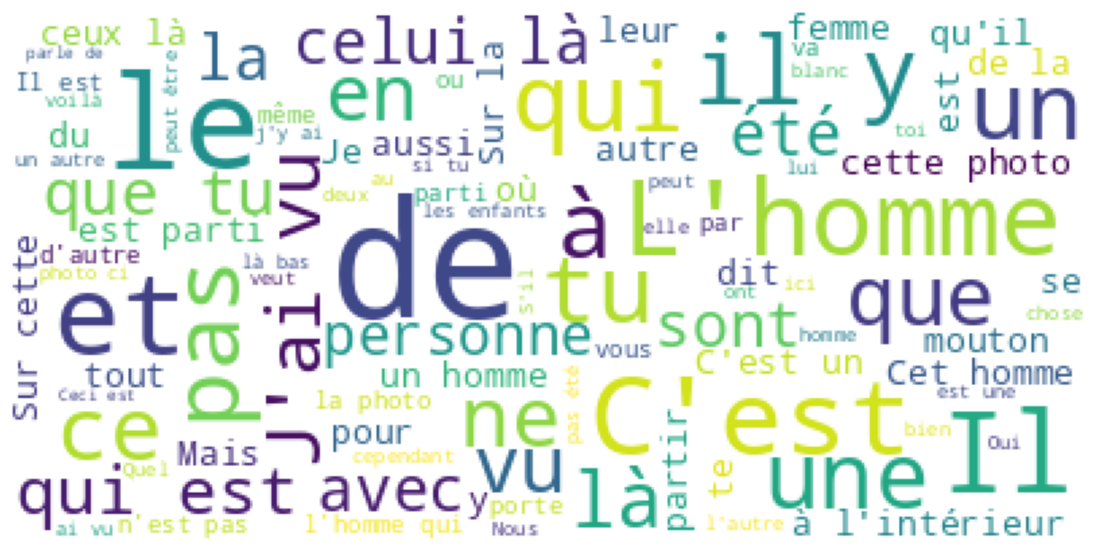



####################################################################################################




In [25]:
french_results = pipeline1.execute_pipeline("nlp_pipeline")

Let us analyze some of the outputs:

- create_corpus: We identified 20356 tokens and 2061 unique tokens in the French corpus. 
- show_most_common_words: The most common words are pronouns, punctuations, attributes, and prepositions, part of stop words. As we specified in the previous sections, they are part of the translation and cannot be removed from the sentences. But they will be investigated later. 
- plot_frequency_histogram: The tokens with a frequency lesser or equal than 8 constitute 85% of the corpus. It is a big issues since a large amount of words appear only on some sentences. Particularly, latter, after splitting the dataset, words (or most of the words) can appear only in the training set and not in the testing and the opposite case is also possible. We will try to generate texts in order to augment the number of sentences and thus obtain more similar tokens. An approach is to used the `nlpaug` library which provide some interesting method for making augmentation.  

- plot_wordcloud: According to the WordCloud, the most common words in the corpus except the stop words are : "homme", "photo", "personne", "intérieur", "mouton", "enfants", "femme", "partir".

Let us recuperate the different results.

In [26]:
tokens, (corpus, corpus_text), (freqs, token_idx) = french_results

The token indices can be used for the machine translation task. Let us show some of them.

In [27]:
pd.Series(token_idx).sample(20)


975         passé
1505     drapeaux
300         quand
1526       autour
348        revenu
1231        route
1291       conçue
211       quelqu'
1244       lèvent
756            ni
719     souverain
2046      pleurer
1281     préparer
1605       tiroir
724       instant
1983     parlerai
745      lui-même
95             Ce
942     Quiconque
1851      entoure
dtype: object

- Wolof corpus: Let us apply the French pipeline to it

In [28]:
# modify the text
pipeline1.corpus = corpora['wolof'].to_list()

Let us execute the pipeline and investigate the results.

Method 1: tokenize_text -> result = True



####################################################################################################


Method 2: create_corpus -> result = True



100%|██████████| 1949/1949 [00:00<00:00, 407207.90it/s]

Number of words: -----------16677
Number of unique words: ------------2287


####################################################################################################


Method 3: create_frequency -> result = False

       index  frequency
0    Demagul          1
1  Seeteegul          1
2  Wuutóogul          1
3   Giséegul          1
4        Nit         75


####################################################################################################


Method 4: show_frequency_out_limits -> result = False

Low limit: -------------3.5
High limit: -------------8.5


####################################################################################################


Method 5: show_most_common_words -> result = False

Most common words are:
('.', ',', '!', 'la', '?', 'ci', 'na', 'dem', 'gi', 'naa', 'ay', 'bi', 'ŋga', 'am', 'Góor', 'mu', 'bu', 'Gis', 'di', 'gis')


####################################################################################################


Meth



####################################################################################################


Method 7: show_n_time_frequency_words -> result = False

Percentage of words appearing 1/2/3/4/5/6/7/8 times in the dataset: 0.8727590730214254%
Words appearing 1/2/3/4/5/6/7/8 times:
          index  frequency
0       Demagul          1
1     Seeteegul          1
2     Wuutóogul          1
3      Giséegul          1
5         bonul          3
18       kookuu          5
22         kale          1
24      kookale          4
25          kee          5
26       kookee          5
29           ju          5
30       Xoolal          3
31         mbër          5
34        sarax          1
37       Xamoon          2
38         jaŋx          2
42        jooju          2
43   Xammeewoon          2
44         jaŋg          1
46         yile          2
47     yarunañu          1
49         jale          2
52          buu          3
53         jule          1
55         yule          1
56     ya

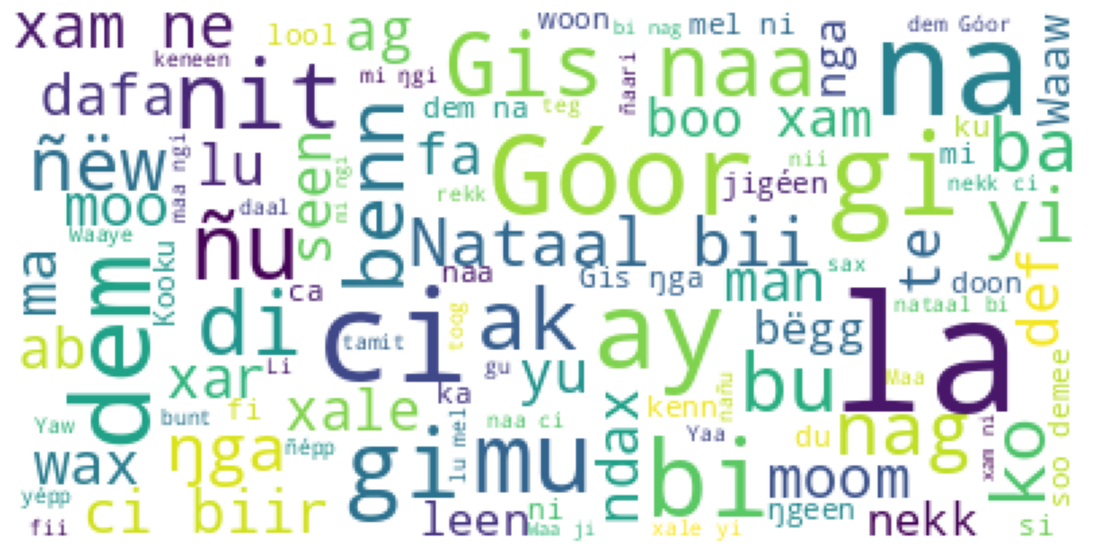



####################################################################################################




In [29]:
wolof_results = pipeline1.execute_pipeline("nlp_pipeline")

Let us analyze some of the outputs:

- create_corpus: We identified 16677 tokens and 2287 unique tokens in the Wolof corpus. 
- show_most_common_words: The most common words are pronouns, punctuations, attributes, and prepositions, part of stop words like for the French corpus.
- plot_frequency_histogram: Like with the French corpus we have a large number of tokens appearing less than 9 times in the corpus. It means that most of them appear only in one sentence or in only few sentences in the corpus. They constitute 87 % of the tokens which is a big part of the total number of tokens. We can make a first data augmentation with the `nlpaug` library.
- plot_wordcloud: According to the WordCloud, the most common words in the corpus except the stop words are : "Goor", "Nataal", "Waaw", "biir", "Gis", "dem", "Nit", "new", "begg", "jigéen", "Xale", "xar". We will guess if it is necessary to remove the most common words latter when testing the translation model. They can add a bias to the model predictions.